# Learning word embeddings

There are several techniques or algorithms to learn or compute word vectors.
The most famous word2vec techniques are:
- Continous Bag Of Words (CBOW)
- Skip-gram
- Glove

There are other techniques also based on attention models.

- Continous Bag Of Words (CBOW):

In this technique, n words before and after a word are considered. Their one-hot vectors are averaged and input to a NN with input size of V, where V is the size of the vocabulary. There is only one hidden layer in the NN and the size of that, N, is assigned to the desired size of learnt word vectors. The output of the NN is also of size V. The output is softmaxed and is compared with one-hot vector under training. The cost function is created based on cross-entropy. The weight matrices will be of size N x V and can be used to extract the desired N size embedding vector for each of the V words in the vocabulary. This notebook illustrates this concept using fundamental NN calculations.

- Skip-gram:

Generally similar to CBOW. We pick two nearby words from the training text, we input the one-hot vector of one of them to the NN and try to predict of the softmaxed output is equal to the one-hot of the other one.
There are several optimization tricks used such as sub-sampling (to account for the frequency of the words in the corpus) and negative sampling (to account for many non-positive outcomes that dont have to be update). 
[More info](https://towardsdatascience.com/word2vec-skip-gram-model-part-1-intuition-78614e4d6e0b)

- Glove:

Glove is based on matrix factorization techniques on the word-context matrix. First a large matrix of (words x context) co-occurrence information, i.e. for each “word” (the rows), you count how frequently we see this word in some “context” (the columns) in a large corpus.  The number of “contexts” is of course large, since it is essentially combinatorial in size.

A lower-dimensional (word x features) matrix, where each row now yields a vector representation for the corresponding word is optimzed minimizing a “reconstruction loss”. This loss tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data. [More info](https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/#:~:text=The%20basic%20idea%20behind%20the,pair%20of%20words%20occurring%20together.)



## Importing libraries

In [1]:
import nltk
import random
import re
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter

nltk.download('punkt')
nltk.data.path.append('.')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading shakespeare corpus as training dataset

Preprocess the data as usual.

In [2]:
import re                                                           
with open('./data/shakespeare.txt') as f:
    data = f.read()                                                 
data = re.sub(r'[,!?;-]', '.',data)                                 
data = nltk.word_tokenize(data)                                     
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    


## Calculate the count of each word

In [3]:
fdist = nltk.FreqDist(word for word in data)
print(fdist)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

<FreqDist with 5775 samples and 60976 outcomes>
Size of vocabulary:  5775
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752), ('you', 748), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


# Create dictionaries

Two dictionaries are created to store the index of each word given a word and also return the word at each index given an index

In [4]:
def get_dict(data):
    word2Ind = {}
    Ind2word = {}
    counter = 0
    fdist = nltk.FreqDist(word for word in data)
    for w in fdist.keys():
        word2Ind[w] = counter
        Ind2word[counter] = w
        counter += 1
    return word2Ind, Ind2word
    

# Creating the simple NN

The NN has one input layer of size V, one hidden layer of size N (the desired size of the word embeddings) and one output layer of size V

Usual steps and functions needed for fundamental implementation of NNs. Also available packages like Tensorflow can be used.
- Initialization
- Forward propagation
- Backward propagation
- Batch return function
- Gradient descent


In [5]:
def initialize_model(N,V):
    W1 = np.random.rand(N, V)
    W2 = np.random.rand(V, N)
    b1 = np.random.rand(N, 1)
    b2 = np.random.rand(V, 1)
    
    return W1, W2, b1, b2

In [6]:
def softmax(z):
    yhat = np.exp(z) / np.sum(np.exp(z), axis = 0)
    return yhat

In [7]:
def forward_prop(x, W1, W2, b1, b2):
    h = np.matmul(W1, x) + b1
    h = np.maximum(h, 0)
    
    z = np.matmul(W2, h) + b2
    return z, h

In [8]:
def compute_cost(y, yhat, batch_size):
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    
    return cost

In [9]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    
    l1 = np.matmul(W2.T, yhat - y)
    l1 = np.maximum(l1, 0) 
    
    grad_W1 = np.dot(l1, x.T) / batch_size
    grad_W2 = np.dot(yhat - y, h.T) / batch_size
    
    grad_b1 = np.sum(l1, axis = 1, keepdims = True) / batch_size
    grad_b2 = np.sum(yhat - y, axis = 1, keepdims = True) / batch_size
    
    return grad_W1, grad_W2, grad_b1, grad_b2

The function below is implemented as an example. It could be optimized and available packages can also be used.
The different hear is that, here, the calculation for x (training batch) and y (label/truth) batch are also done. The calculations use the pre-calculated dictionaries of words vs word-indices

In [10]:
def my_get_batches(data, word2Ind, V, C, batch_size = 128):
    while True:
        num_batches = (len(data) - C) // batch_size
        for i in range(num_batches - 1):
            indices = random.sample(range(C, len(data) - C), 128)
            this_batch = []
            x = np.zeros((V, batch_size), dtype = float)
            y = np.zeros((V, batch_size), dtype = float)
            for j in range(batch_size):
                start = indices[j]
                for k in range(1, C + 1, 1):
                    x[word2Ind[data[start - k]]][j] += 1
                    x[word2Ind[data[start + k]]][j] += 1
                y[word2Ind[data[start]]][j] = 1
            x /= (2 * C)
            yield x, y

## Model Training

In [14]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=my_get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    W1, W2, b1, b2 = initialize_model(N,V)

    batch_size = 128
    iters = 0
    C = 2 
    
    for x, y in my_get_batches(data, word2Ind, V, C, batch_size):
        
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} completed")
            
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [15]:
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 completed
iters: 20 completed
iters: 30 completed
iters: 40 completed
iters: 50 completed
iters: 60 completed
iters: 70 completed
iters: 80 completed
iters: 90 completed
iters: 100 completed
iters: 110 completed
iters: 120 completed
iters: 130 completed
iters: 140 completed
iters: 150 completed


## Testing the model

An array of words is created and their embedding is printed

In [16]:
from matplotlib import pyplot

words = ['king', 'queen','lord','man', 'woman','dog','wolf',
         'rich','happy','sad', 'young']

embs = (W1.T + W2)/2.0
 
idx = [word2Ind[word] for word in words]
X = embs[idx, :]

for word in words[:3]:
    index = word2Ind[word]
    print("Embedding of |{}| is {}: ".format(word, embs[index,:]))

Embedding of |king| is [0.19991177 0.78386321 0.65540417 0.50056632 0.68348011 0.61871161
 0.33244765 0.36249699 0.47070768 0.55106763 0.21355413 0.43279105
 0.45811958 0.19142544 0.16966585 0.1682538  0.689281   0.94125917
 0.08626993 0.452611   0.38224913 0.77522007 0.23241242 0.19160534
 0.53893683 0.53779821 0.86170196 0.37058287 0.48734814 0.20682348
 0.74344852 0.7572905  0.31464416 0.95587407 0.40880683 0.61454012
 0.23453226 0.29575051 0.8296693  0.80254727 0.46157702 0.44038062
 0.71736285 0.41910073 0.70223745 0.2183107  0.53795768 0.3609458
 0.85127576 0.7555842 ]: 
Embedding of |queen| is [0.39536953 0.78341041 0.30443121 0.02215249 0.54722169 0.19491201
 0.91580118 0.46199161 0.42572371 0.35477202 0.21248158 0.59196456
 0.51935354 0.03971138 0.63322017 0.40661889 0.59830069 0.41463781
 0.556516   0.46224308 0.39296425 0.67493232 0.26148645 0.05587954
 0.61918102 0.44264325 0.40712918 0.68841236 0.58539649 0.37318218
 0.07064848 0.37751788 0.85233319 0.44384501 0.05667696 0

## Visualizing the word embeddings

This is simple model and not optimal. But we can still use unsupervised learning techniques to visualize the dimensionally reduced word vectors.

We can implement this using PCA.

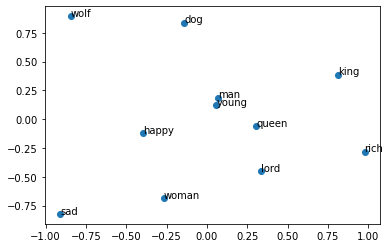

In [17]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(X)
result=  pca.transform(X)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

## Probably King is Rich and every man is young! (In shakespeare work at least)